<img src="../images/AzPTravel_PPM.png">

## Read in Data Collection Source

#### This script fetches the current data collection submission file from the completed "prep.ipynb" step into the pipeline.


### User Variables
- These are overwritten if inherited from run_control.ipynb.
- Feel Free to reset them for a manual run if you like
- Do not save without percode = "-f"

In [1]:
commit_message = "Development and testing."
# Give a brief reason for the run.

run_control = 1
#run_type = 0 - Lite run with no reporting, not recommended.
#run_type = 1 - Lite run with normal reporting, default setting.
#run_type = 2 - Heavy run with full reporting, available for audits and troubleshooting.
#run_type = 5 - A default setting. Indicates the script is being run by an outside process without an inherited value

percode = "2021.Q1"
# Data Collection Code, this controls file paths and output names
# "-f" is the value indicating a bad inheritance from run with arg

#----------
# do not edit - this either inherits the full instance timestamp from the papermill book or captures the run time of this script.
from datetime import datetime
inst_datetime = datetime.now().strftime("%m%d%Y%H%M%S")

In [2]:
# Parameters
run_control = 1
percode = "2021.Q1"
commit_message = "Strange etnry found in the 'type of account'."
inst_datetime = "05262021092926"


#### import packages

In [3]:
import os # System commands
import sys # System commands

import getpass # parquet file read/write
import json # json file read/write
from sklearn import datasets # pass vars between .ipynb s

import matplotlib.pyplot as plt #Plots and Graphs
import pandas as pd #DataFrame and math


#### Default Variables, these govern logic, do not edit.

In [4]:
default_dc = "20XX.QX"
default_rc = 0 #extra lite mode
dummy_perc = "33Q3" # bad inheritance

#### Script determining run context ie, manual, run_control.ipynb, or other.

In [5]:
if run_control == 5:
    
    run_control = default_rc
    
else:
    
    run_control = run_control

try:
    
    if sys.argv[1] == "-f":
        
        percode = percode
        
    else:
        
        percode = sys.argv[1]

except IndexError:
    
    percode = default_dc

except NameError:

    percode = default_dc


#### style settings

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Make paths for the source folder

In [7]:
rt_path = os.path.join(f'\\\\hecate\Insurance_US\Product Development\Product Management\Global PPM\Reporting\Data Collection\Production',percode)

#archive folders
rawpath = os.path.join(rt_path, "logs", "raw_data_file_history")
localpath = os.path.join(rt_path, "logs", "local_currency_source_history")
europath = os.path.join(rt_path, "logs", "euro_source_history")

#script folder
scriptpath = os.path.abspath(os.path.join(rt_path, '..', '..', "Pipeline Reporting Scripts","GPMpipeline"))

piperunner = '//hecate/Insurance_US/Product Development/Product Management/Global PPM/Reporting/_Tools/GitHub/Production Repositories/Pipeline Runner/Pipeline Runner.xlsm'


#### Set file variables

In [8]:
rawfile = f'{str(percode)}.csv'
parqfile = f'{str(percode)}.parquet'
rawhistfile = f'{percode}_{inst_datetime}.csv'

prepfile = f"{percode}prep.csv"
prepparq = f"{percode}prep.parquet"
prephistfile = f'{percode}_{inst_datetime}prep.csv'

localfile = f'{percode}.localcur.csv'
localhistfile = f'{percode}.localcur_{inst_datetime}.csv'

eurofile = f'{percode}.euroconv.csv'
eurohistfile = f'{percode}.euroconv_{inst_datetime}.csv'

xls_runner = 'Pipeline Runner.xlsm'



- Read each json file into temp DataFrame "data".
- Prep actions - Strip (trim) leading and trailing spaces values in string columns, remove rows without business units.
- Append each json output to into 1 DataFrame "df".
- Process Cleanup, the indices restart with each append, reset and drop the previous.

In [9]:

try:
    %store -r prep_df
    df = prep_df

except:
    
    try:
        df = pd.read_parquet(os.path.join(rt_path,prepparq), engine = "pyarrow")
    
    except:
        df = pd.read_csv(os.path.join(rt_path,prepfile) )

if run_control > 0:
     
    try:
        os.remove(prepfile)
    
    except FileNotFoundError:
        pass
    
    try:
        os.remove(prepparq)

    except FileNotFoundError:
        pass
        
else:

    pass

#### Upload Charts

<BarContainer object of 9 artists>

Text(0.5, 1.0, 'Earned Revenue net of Taxes by BU in thousands LC')

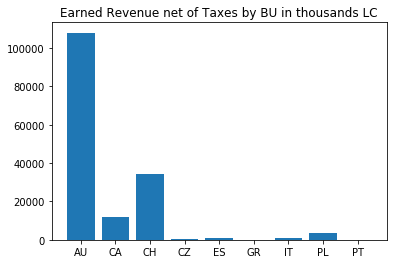

<BarContainer object of 9 artists>

Text(0.5, 1.0, 'Row Counts by BU')

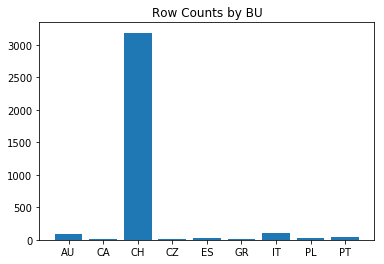

In [10]:
def num_format(x):
    """number format without a currency"""
    return "{:,.0f}".format(x)

if run_control > 0:

    sumdata = df.groupby(['Business Unit']).sum()
    sumdata = sumdata.reset_index()
    plt.bar(sumdata['Business Unit'], sumdata['Earned Revenues net of Taxes']/1000)
    plt.title('Earned Revenue net of Taxes by BU in thousands LC')
    plt.show()

    countdata = df.groupby(['Business Unit']).count()
    countdata = countdata.reset_index()
    plt.bar(countdata['Business Unit'], countdata['Earned Revenues net of Taxes'])
    plt.title('Row Counts by BU')
    plt.show()

else:
    print("Charts Skipped")

#### Output Processes
- Define File names.
- If existing csv is found, archive it in "raw_data_file_history" folder.
- Save new csv.

In [11]:
if run_control > 0:
    
    try:
        os.rename(os.path.join(rt_path , rawfile), os.path.join(rawpath , rawhistfile))
    except FileNotFoundError:
        pass
    try:
         os.rename(os.path.join(rt_path , prepfile), os.path.join(rawpath , prephistfile))
    except FileNotFoundError:
        pass
    try:
         os.rename(os.path.join(rt_path , localfile), os.path.join(localpath , localhistfile))
    except FileNotFoundError:
        pass
    try:
         os.rename(os.path.join(rt_path , eurofile), os.path.join(europath , eurohistfile))
    except FileNotFoundError:
        pass

    df.to_csv(os.path.join(rt_path , rawfile), ',', index=False , encoding='utf-8-sig')
    df.to_parquet(os.path.join(rt_path , parqfile), engine = "pyarrow") 

else:
    
    pass

- Log update record with commit message and time.
- Determine commit message and make new entry

In [12]:
log = os.path.join(rt_path, "logs", 'pipline_log.csv' )

try:
    log_df = pd.read_csv(log)
except NameError:
    print("No log file present")

# determine if running from notebook or Excel controller and set commit message.
if sys.argv[1] == "-f":
    message = commit_message
else:
    piperunner = os.path.join(scriptpath, xls_runner)
    wb = openpyxl.load_workbook(piperunner)
    sh = wb['Pipeline Runner']
    message = {sh['f13'].value}

# find username
username = getpass.getuser()

# file links
rawlink = f'=HYPERLINK("{os.path.join(rawpath,rawhistfile)}")'
locallink = f'=HYPERLINK("{os.path.join(localpath,localhistfile)}")'
eurolink = f'=HYPERLINK("{os.path.join(europath,eurohistfile)}")'

# record timestamp
datetime = inst_datetime
dateformat = datetime[4:8] + '-' + datetime[:2]  + '-' + datetime[2:4]  + '-' + datetime[8:]

# add new line
newline = { "run_message" : [message ],  "datetime" :[dateformat], "user" : [username ],
          
          "raw_archive" : [rawlink] ,"local_archive" :	[locallink],"euro_archive" : [eurolink] }


newline = pd.DataFrame.from_dict(newline)

# make new file
log_df = log_df.append(newline[0:])
log_df
log_df.to_csv(log, ',', index=False , encoding='utf-8-sig')


,run_message\tdatetime\tuser,run_message,datetime,user,raw_archive,local_archive,euro_archive
0,NaN,Got something new it.,2021-05-21-090854,gharmo,NaN,NaN,NaN
1,NaN,Changed some folder names.,2021-05-21-153222,gharmo,NaN,NaN,NaN
2,NaN,Added finance report to the process flow.,2021-05-21-163305,gharmo,NaN,NaN,NaN
3,NaN,Added finance report to the process flow.,2021-05-21-165556,gharmo,NaN,NaN,NaN
4,NaN,Added finance report to the process flow.,2021-05-22-163757,gharmo,NaN,NaN,NaN
5,NaN,Development and testing.,2021-05-22-164026,gharmo,NaN,NaN,NaN
6,NaN,Development and testing.,2021-05-22-164505,gharmo,NaN,NaN,NaN
7,NaN,Added finance report to the process flow.,2021-05-22-164644,gharmo,NaN,NaN,NaN
8,NaN,Added finance report to the process flow.,2021-05-22-171225,gharmo,NaN,NaN,NaN
9,NaN,Added finance report to the process flow.,2021-05-22-171928,gharmo,NaN,NaN,NaN


#### Store the DataFrame for other noteboks to use

In [13]:
read_dc_df = df

%store read_dc_df


Stored 'read_dc_df' (DataFrame)
